In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

import iflow

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
# tf.compat.v1.enable_eager_execution()
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())


# tf.compat.v1.disable_eager_execution()
# tf.config.threading.set_inter_op_parallelism_threads(64)
# tf.config.threading.set_intra_op_parallelism_threads(64)

0
0


In [6]:
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

0
0


In [7]:
def start_profiling():
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = 'logs/func/%s' % stamp

    # Start tracing.                                                                                                                                                                              
    options = tf.profiler.experimental.ProfilerOptions(
        host_tracer_level=3, python_tracer_level=1, device_tracer_level=1, delay_ms=None
    )

    tf.profiler.experimental.start(logdir, options = options)
    return logdir
    
    
def end_profiling():
    tf.profiler.experimental.stop()

In [8]:
# c1 = tf.random.uniform(shape=(10,6), minval=0, maxval=10, dtype=tf.float64)
# c2 = tf.random.uniform(shape=(2,9), minval=0, maxval=.04, dtype=tf.float64)

In [9]:
# x = tf.compat.v1.placeholder(tf.float64, shape=[None])

# with tf.compat.v1.Session() as sess:

#     #writer = tf.summary.create_file_writer(logdir)

#     #tf.profiler.experimental.start(logdir, options = options)                                                                                                                                
#     #tf.summary.trace_on(graph=True, profiler=True)

#     print(
#         sess.run(
#             f1(c1),
# #             feed_dict={
# #                 x: np.ones(4, dtype=np.int)
# #             }
#         )
#     )

# #f1(c1)

In [10]:
def build(in_features, out_features, options):
    """ Builds a dense NN.

    The output layer is initialized to 0, so the first pass
    before training gives the identity transformation.

    Arguments:
        in_features (int): dimensionality of the inputs space
        out_features (int): dimensionality of the output space
        options: additional arguments, not used at the moment

    Returns:
        A tf.keras.models.Model instance

    """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features, bias_initializer='zeros',
                                    kernel_initializer='zeros')(hidden)
    model = tf.keras.models.Model(invals, outputs)
    #model.summary()
    return model


def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    # n_masks = 5
    
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks


def build_iflow(func, ndims):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,
                           reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    integrate = integrator.Integrator(func, dist, optimizer,
                                      loss_func='exponential')

    return integrate


def train_iflow(integrate, ptspepoch, epochs):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        epochs (int): number of epochs for training

    Returns:
        numpy.ndarray(float): value of loss (mean) and its uncertainty (standard deviation)

    """
    means = np.zeros(epochs)
    stddevs = np.zeros(epochs)
    for epoch in range(epochs):
        loss, integral, error = integrate.train_one_step(ptspepoch,
                                                         integral=True)
        means[epoch] = integral
        stddevs[epoch] = error
        _, current_precision = variance_weighted_result(means[:epoch+1], stddevs[:epoch+1])
        if epoch % 1 == 0:
            print('Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, loss,
                                                                     integral, error,
                                                                     current_precision))

    return means, stddevs

def train_iflow_target(integrate, ptspepoch, target):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        target (float): target precision of final integral

    Returns:
        numpy.ndarray(float): integral estimations and its uncertainty of each epoch

    """
    means = []
    stddevs = []
    current_precision = 1e99
    epoch = 0
    while current_precision > target:
        loss, integral, error = integrate.train_one_step(ptspepoch,
                                                         integral=True)
        means.append(integral)
        stddevs.append(error)
        _, current_precision = variance_weighted_result(np.array(means), np.array(stddevs))
        if epoch % 10 == 0:
            print('Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, loss,
                                                                     integral, error,
                                                                     current_precision))
        epoch += 1
    return np.array(means), np.array(stddevs)

def sample_iflow(integrate, ptspepoch, epochs):
    """ Sample from the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        epochs (int): number of epochs for training

    Returns:
        (tuple): mean and stddev numpy arrays

    """
    # defining a reduced number of epochs for integral evaluation
    red_epochs = int(epochs/5)

    # mean and stddev of trained NF
    print('Estimating integral from trained network')
    means_t = []
    stddevs_t = []
    for _ in range(red_epochs+1):
        mean, var = integrate.integrate(ptspepoch)
        means_t.append(mean)
        stddevs_t.append(tf.sqrt(var/(ptspepoch-1.)).numpy())
    return np.array(means_t), np.array(stddevs_t)

def rel_unc(mean_a, unc_a, mean_b, unc_b):
    """  Relative uncertainty, for Table III """
    ret = mean_a - mean_b
    sqr = np.sqrt(unc_a**2 + unc_b**2)
    ret = ret/sqr
    return ret

def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

def variance_unweight(means_wgt, stddevs_wgt):
    """ Computes mean and stddev of individual run given
        means and stddevs arrays that are weighted with
        Inverse-variance weighting up to that run
    """
    inv_var = 1./stddevs_wgt[1:]**2 - 1./stddevs_wgt[:-1]**2
    stddevs = 1./np.sqrt(inv_var)
    stddevs = np.insert(stddevs, 0, stddevs_wgt[0])
    means = means_wgt[1:]/(stddevs_wgt[1:]**2) - means_wgt[:-1]/(stddevs_wgt[:-1]**2)
    means *= stddevs[1:]**2
    means = np.insert(means, 0, means_wgt[0])
    return means, stddevs

In [11]:
# ndims = 9
# sigma = 0.01
# alpha = sigma * np.sqrt(2)

# @tf.function(input_signature=[tf.TensorSpec(shape=(None,9), dtype=tf.float64)])
# def f2(x):
#     pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndims, dtype=tf.float64)
#     exponent = -1 * tf.reduce_sum(x ** 2, axis=-1) / alpha ** 2
#     return pre * tf.exp(exponent)

### F1

In [111]:
target = 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) **7

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(-49.165073816419444, 0.001)

In [112]:
import tensorflow_addons as tfa

tfa.__version__

'0.16.1'

In [113]:
def build_iflow(func, ndims, low=0, high=1):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    masks = np.vstack([binary_masks(ndims), binary_masks(ndims)])
    
    
    bijector = []
    for mask in masks:
#         bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
#                                                              num_bins=16,
#                                                              blob=None,
#                                                              options=None))
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                     num_bins=16,
                                                     blob=None,
                                                     options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.full(ndims, low, dtype=np.float64)
    high = np.full(ndims, high, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist, reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tfa.optimizers.AdamW(weight_decay=1e-3, learning_rate=1e-4)
    
    integrate = integrator.Integrator(func, dist, optimizer, loss_func='exponential')
    # integrate = integrator.Integrator(func, dist, optimizer, loss_func='kl')

    return integrate

#### Simple

In [114]:
# ndims = 6

# @tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
# def f1(x):
#     """
#         https://stackoverflow.com/questions/52774351/how-to-run-parallel-map-fn-when-eager-execution-enabled
#     """
#     return tf.sin(tf.reduce_sum(x, axis=-1))


# def f1_np(x):
#     return np.sin(np.sum(x, axis=-1))

In [115]:
# @tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
# def f1(x):
#     """
#         https://stackoverflow.com/questions/52774351/how-to-run-parallel-map-fn-when-eager-execution-enabled
#     """
#     return tf.sin(tf.reduce_sum(x, axis=-1) * 10) * 10 ** ndims

In [ ]:
target = 8 * np.cos(5) * np.sin(5) ** 3
print(target)

ndims = 2

@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def f1(x):
    return tf.sin(tf.reduce_sum(x, axis=-1) * 10) * 10 ** ndims


def f1_np(x):
    return np.sin(np.sum(x, axis=-1))

In [118]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e6]))
run_lst = list(range(1,2))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        
        integrate = build_iflow(f1, ndims, low=0, high=1)
        mean_t, err_t = train_iflow(integrate, ptspepoch=neval, epochs=10)
        
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)
        
        # current_result_mean = tf.reduce_mean(current_result).numpy()
        # current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(iflow_mean_wgt)
        results_stddevs.append(iflow_err_wgt)
        # results.append(current_result)
        
        print("wResult {:.5e} +/- {:.5e}, relUncertainty {:.5e}"
              .format(iflow_mean_wgt, iflow_err_wgt, rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))

run=1 neval=1000000
Epoch:   0 Loss = 1.990598e-01 Integral = 6.357126e+01 +/- 3.077374e-02 Total uncertainty = 3.077374e-02
Epoch:   1 Loss = 1.975472e-01 Integral = 6.364183e+01 +/- 3.069074e-02 Total uncertainty = 2.173092e-02
Epoch:   2 Loss = 1.975012e-01 Integral = 6.362522e+01 +/- 3.068300e-02 Total uncertainty = 1.773374e-02
Epoch:   3 Loss = 1.967514e-01 Integral = 6.362508e+01 +/- 3.061986e-02 Total uncertainty = 1.534585e-02
Epoch:   4 Loss = 1.968392e-01 Integral = 6.359800e+01 +/- 3.060950e-02 Total uncertainty = 1.371837e-02


KeyboardInterrupt: 

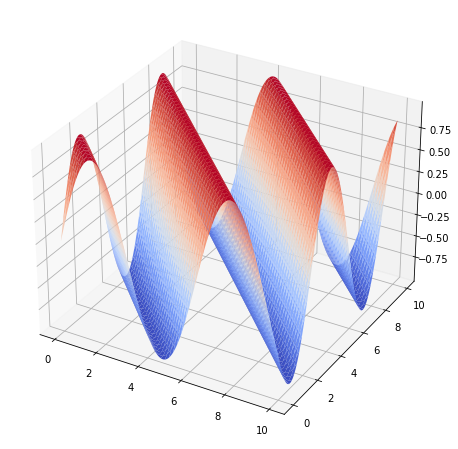

In [119]:
def f1_plot(x,y):
    return np.sin(x+y)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 10, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(f1_plot(np.ravel(X), np.ravel(Y)))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm')

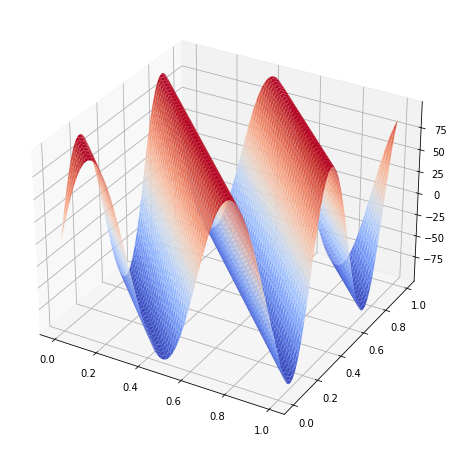

In [121]:
def f1_plot(x,y):
    return np.sin(10*x+10*y) * 10 ** 2

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 1, 0.005)
X, Y = np.meshgrid(x, y)
zs = np.array(f1_plot(np.ravel(X), np.ravel(Y)))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm')

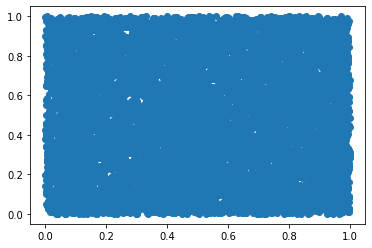

In [45]:
# integrate = build_iflow(f1, ndims, low=0, high=100)

a = integrate.sample(10000).numpy()#[:, :2]
plt.scatter(a[:, 0], a[:, 1])

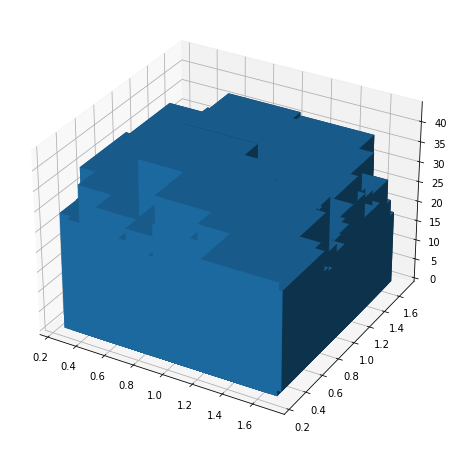

In [46]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
x, y = a[:, 0], a[:, 1]
hist, xedges, yedges = np.histogram2d(x, y, bins=20, range=[[0, 1], [0, 1]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', cmap='coolwarm')

plt.show()

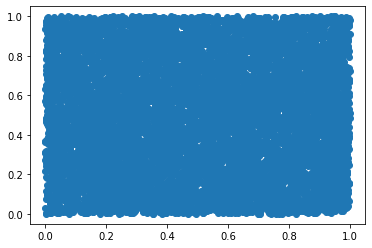

In [106]:
integrate = build_iflow(f1, ndims, low=0, high=1)

a = integrate.sample(10000).numpy()#[:, :2]
plt.scatter(a[:, 0], a[:, 1])

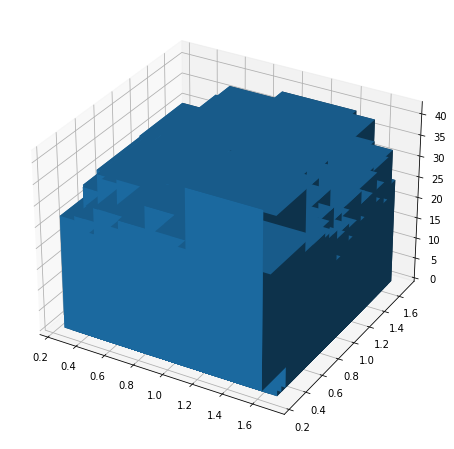

In [107]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
x, y = a[:, 0], a[:, 1]
hist, xedges, yedges = np.histogram2d(x, y, bins=20, range=[[0, 1], [0, 1]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

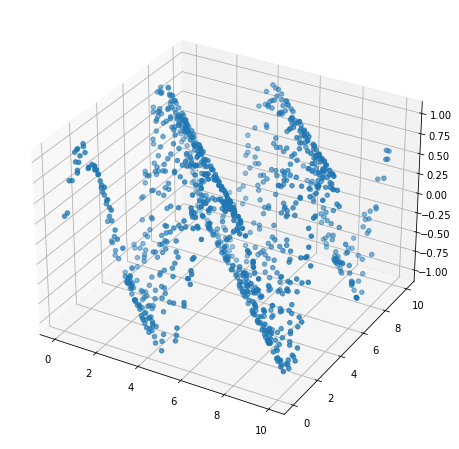

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(data[0, :, 0], data[0, :, 1], zz[0, :])

Epoch:   0 Loss = 2.014326e-01 Integral = 6.327399e+01 +/- 3.087342e-01 Total uncertainty = 3.087342e-01


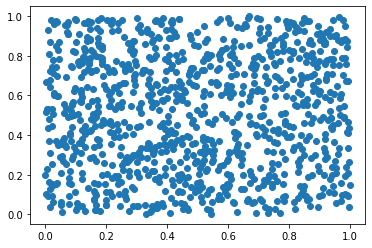

In [38]:
train_iflow(integrate, ptspepoch=neval, epochs=1)

a = integrate.sample(1000).numpy()[:, :2]
plt.scatter(a[:, 0], a[:, 1])

In [ ]:
temp_df = pd.DataFrame({'neval': neval_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [ ]:
temp_df

In [ ]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

In [ ]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Simple')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [ ]:
temp_df.groupby('neval')['result_means'].agg([np.mean, np.std])

In [ ]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

In [ ]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

In [ ]:
plt.title('IFLOW Simple')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### Precompute

In [ ]:
ndims = 6

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def f1(x):
    """
        https://stackoverflow.com/questions/52774351/how-to-run-parallel-map-fn-when-eager-execution-enabled
    """
    return tf.sin(tf.reduce_sum(x, axis=-1))

In [ ]:
ndims = 6

In [ ]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e4, 1e5, 1e6]))
run_lst = list(range(1,11))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        
        integrate = build_iflow(f1, ndims)
        
        # precompute on 100% neval
        train_iflow(integrate, ptspepoch=neval, epochs=10)
        
        mean_t, err_t = train_iflow(integrate, ptspepoch=neval, epochs=10)
        
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)
        
        # current_result_mean = tf.reduce_mean(current_result).numpy()
        # current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(iflow_mean_wgt)
        results_stddevs.append(iflow_err_wgt)
        # results.append(current_result)
        
        print("wResult {:.5e} +/- {:.5e}, relUncertainty {:.5e}"
              .format(iflow_mean_wgt, iflow_err_wgt, rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))

### F2

In [48]:
target = 1

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(1, 0.001)

In [49]:
import tensorflow_addons as tfa

tfa.__version__

'0.16.1'

In [51]:
def build_iflow(func, ndims, low=0, high=1):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.full(ndims, low, dtype=np.float64)
    high = np.full(ndims, high, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist, reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tfa.optimizers.AdamW(weight_decay=1e-3, learning_rate=1e-3)
    
    integrate = integrator.Integrator(func, dist, optimizer, loss_func='exponential')
    # integrate = integrator.Integrator(func, dist, optimizer, loss_func='kl')

    return integrate

#### Simple

In [109]:
ndims = 2
sigma = 0.01
alpha = sigma * np.sqrt(2)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def f2(x):
    pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndims, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum(x ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

In [110]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e6]))
run_lst = list(range(1,2))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        
        integrate = build_iflow(f2, ndims, low=-1, high=1)
        mean_t, err_t = train_iflow(integrate, ptspepoch=neval, epochs=10)
        
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)
        
        # current_result_mean = tf.reduce_mean(current_result).numpy()
        # current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(iflow_mean_wgt)
        results_stddevs.append(iflow_err_wgt)
        # results.append(current_result)
        
        print("wResult {:.5e} +/- {:.5e}, relUncertainty {:.5e}"
              .format(iflow_mean_wgt, iflow_err_wgt, rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))

run=1 neval=1000000
Epoch:   0 Loss = 6.245716e+01 Integral = 9.109104e-01 +/- 5.381884e-02 Total uncertainty = 5.381884e-02
Epoch:   1 Loss = 6.107035e+01 Integral = 1.025889e+00 +/- 5.761958e-02 Total uncertainty = 3.933073e-02
Epoch:   2 Loss = 5.946377e+01 Integral = 1.119339e+00 +/- 5.909613e-02 Total uncertainty = 3.274219e-02
Epoch:   3 Loss = 6.102164e+01 Integral = 9.892812e-01 +/- 5.557733e-02 Total uncertainty = 2.821059e-02
Epoch:   4 Loss = 6.208361e+01 Integral = 9.185219e-01 +/- 5.337489e-02 Total uncertainty = 2.494120e-02
Epoch:   5 Loss = 6.111854e+01 Integral = 9.381942e-01 +/- 5.307317e-02 Total uncertainty = 2.257290e-02
Epoch:   6 Loss = 4.183648e+01 Integral = 1.348611e+00 +/- 5.213810e-02 Total uncertainty = 2.071483e-02
Epoch:   7 Loss = 1.716547e+01 Integral = 8.778922e+00 +/- 8.554817e-02 Total uncertainty = 2.013301e-02
Epoch:   8 Loss = 1.255785e+01 Integral = 4.389818e+01 +/- 2.750724e-01 Total uncertainty = 2.007930e-02
Epoch:   9 Loss = 9.867310e+00 Inte

In [87]:
target = math.erf(1/(2*alpha)) ** ndims

ndims = 2
sigma = 0.01
alpha = sigma * np.sqrt(2)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def f2(x):
    pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndims, dtype=tf.float64)
    exponent = -1.0 * tf.reduce_sum((2*x-1) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent) * 2

In [97]:
target = math.erf(1/(2*alpha)) ** ndims

ndims = 2
alpha = 0.01 * np.sqrt(2)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def gauss(x):
        pre = tf.cast(1.0/(alpha * tf.sqrt(np.pi))**ndims, dtype=tf.float64)
        exponent = -1.0*tf.reduce_sum(((x-0.5)**2)/alpha**2, axis=-1)
        return pre * tf.exp(exponent)

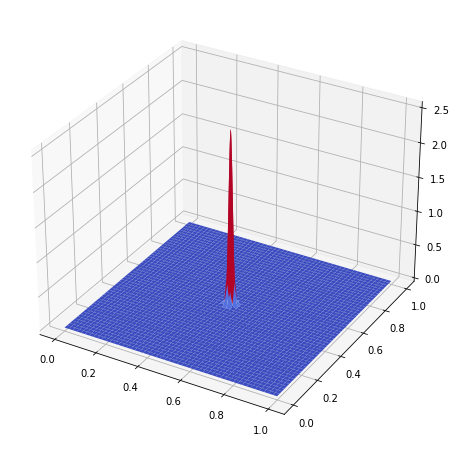

In [100]:
# def f2_plot(x):
#     pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndims, dtype=tf.float64)
#     exponent = -1 * tf.reduce_sum(x ** 2, axis=-1) / alpha ** 2
#     return pre * tf.exp(exponent).numpy()

# def f2_plot(x):
#     pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndims, dtype=tf.float64)
#     exponent = -1 * tf.reduce_sum((2*x-1) ** 2, axis=-1) / alpha ** 2
#     return pre * tf.exp(exponent).numpy() * 2

def gauss_plot(x):
        pre = tf.cast(1.0/(alpha * tf.sqrt(np.pi))**ndims, dtype=tf.float64)
        exponent = -1.0*tf.reduce_sum(((x-0.5)**2)/alpha**2, axis=-1)
        return pre * tf.exp(exponent).numpy()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
zs = np.array(gauss_plot(np.vstack([np.ravel(X), np.ravel(Y)]).T))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm')

In [108]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e6]))
run_lst = list(range(1,2))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        
        integrate = build_iflow(gauss, ndims, low=0, high=1)
        mean_t, err_t = train_iflow(integrate, ptspepoch=neval, epochs=50)
        
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)
        
        # current_result_mean = tf.reduce_mean(current_result).numpy()
        # current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(iflow_mean_wgt)
        results_stddevs.append(iflow_err_wgt)
        # results.append(current_result)
        
        print("wResult {:.5e} +/- {:.5e}, relUncertainty {:.5e}"
              .format(iflow_mean_wgt, iflow_err_wgt, rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))

run=1 neval=1000000
Epoch:   0 Loss = 1.591671e+02 Integral = 9.102618e-01 +/- 5.711425e-01 Total uncertainty = 5.711425e-01
Epoch:   1 Loss = 1.431229e+02 Integral = 5.685535e-01 +/- 2.641760e-01 Total uncertainty = 2.397697e-01
Epoch:   2 Loss = 1.472035e+02 Integral = 7.551827e-01 +/- 4.298269e-01 Total uncertainty = 2.093940e-01
Epoch:   3 Loss = 1.536051e+02 Integral = 3.373298e+00 +/- 1.740893e+00 Total uncertainty = 2.078956e-01
Epoch:   4 Loss = 1.566023e+02 Integral = 4.579835e-01 +/- 3.090075e-01 Total uncertainty = 1.724910e-01
Epoch:   5 Loss = 1.378287e+02 Integral = 4.873147e-01 +/- 2.175736e-01 Total uncertainty = 1.351667e-01
Epoch:   6 Loss = 1.418333e+02 Integral = 3.014681e-01 +/- 1.409826e-01 Total uncertainty = 9.756855e-02
Epoch:   7 Loss = 1.439051e+02 Integral = 6.478840e-01 +/- 2.974722e-01 Total uncertainty = 9.270914e-02
Epoch:   8 Loss = 1.667556e+02 Integral = 7.553656e-01 +/- 5.624738e-01 Total uncertainty = 9.147492e-02
Epoch:   9 Loss = 1.394281e+02 Inte

KeyboardInterrupt: 

In [103]:
def F(x, m, sigma):
    return (1 + math.erf((x - m) / sigma / np.sqrt(2))) / 2

In [105]:
# [-1,1]
print(F(1,0,0.01) - F(-1,0,0.01))

# [0,1]
print(F(1,0.5,0.01) - F(0,0.5,0.01))

1.0
1.0


### F3

In [33]:
target = 1

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(1, 0.001)

In [34]:
import tensorflow_addons as tfa

tfa.__version__

'0.16.1'

In [41]:
def build_iflow(func, ndims, low=0, high=1):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.full(ndims, low, dtype=np.float64)
    high = np.full(ndims, high, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist, reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    # optimizer = tfa.optimizers.AdamW(weight_decay=1e-3, learning_rate=1e-3)
    
    integrate = integrator.Integrator(func, dist, optimizer, loss_func='exponential')
    # integrate = integrator.Integrator(func, dist, optimizer, loss_func='kl')

    return integrate

#### Simple

In [37]:
ndims = 4
alpha = 0.2

@tf.function(input_signature=[tf.TensorSpec(shape=(None,ndims), dtype=tf.float64)])
def camel(x):
        """ Based on eq. 17 of [1], Camel function.

        The Camel function consists of two Gaussians, centered at
        (1/3, 2/3) in each dimension.

        Integral equals
            (0.5*(erf(1/(3*alpha)) + erf(2/(3*alpha)) ))** ndims

        Args:
            x (tf.Tensor): Tensor with batch of points to evaluate

        Returns: tf.Tensor: functional values at the given points

        """
        pre = tf.cast(1./(alpha*tf.sqrt(np.pi))**ndims, dtype=tf.float64)
        exponent1 = -1.*tf.reduce_sum(((x-(1./3.))**2)/alpha**2, axis=-1)
        exponent2 = -1.*tf.reduce_sum(((x-(2./3.))**2)/alpha**2, axis=-1)
        return 0.5*pre*(tf.exp(exponent1)+tf.exp(exponent2))

In [38]:
import math

target = (0.5*(math.erf(1/(3.*alpha))+math.erf(2/(3.*alpha))))**ndims
target

0.9636569684018041

In [39]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e5]))
run_lst = list(range(1,2))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        
        integrate = build_iflow(camel, ndims)
        mean_t, err_t = train_iflow(integrate, ptspepoch=neval, epochs=20)
        
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        iflow_mean_wgt, iflow_err_wgt = variance_weighted_result(mean_t, err_t)
        
        # current_result_mean = tf.reduce_mean(current_result).numpy()
        # current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(iflow_mean_wgt)
        results_stddevs.append(iflow_err_wgt)
        # results.append(current_result)
        
        print("wResult {:.5e} +/- {:.5e}, relUncertainty {:.5e}"
              .format(iflow_mean_wgt, iflow_err_wgt, rel_unc(iflow_mean_wgt, iflow_err_wgt, target, 0.)))

run=1 neval=100000
Epoch:   0 Loss = 4.155101e+00 Integral = 9.621318e-01 +/- 8.344138e-03 Total uncertainty = 8.344138e-03
Epoch:   1 Loss = 4.124441e+00 Integral = 9.799701e-01 +/- 8.432680e-03 Total uncertainty = 5.931253e-03
Epoch:   2 Loss = 4.065789e+00 Integral = 9.647405e-01 +/- 8.223543e-03 Total uncertainty = 4.810556e-03
Epoch:   3 Loss = 4.006356e+00 Integral = 9.698798e-01 +/- 8.175313e-03 Total uncertainty = 4.146040e-03
Epoch:   4 Loss = 3.884213e+00 Integral = 9.804091e-01 +/- 8.073149e-03 Total uncertainty = 3.688112e-03
Epoch:   5 Loss = 3.839268e+00 Integral = 9.483677e-01 +/- 7.761429e-03 Total uncertainty = 3.331150e-03
Epoch:   6 Loss = 3.750576e+00 Integral = 9.619052e-01 +/- 7.718593e-03 Total uncertainty = 3.058474e-03
Epoch:   7 Loss = 3.637938e+00 Integral = 9.606349e-01 +/- 7.558692e-03 Total uncertainty = 2.835173e-03
Epoch:   8 Loss = 3.602439e+00 Integral = 9.548093e-01 +/- 7.458834e-03 Total uncertainty = 2.650177e-03
Epoch:   9 Loss = 3.475575e+00 Integ

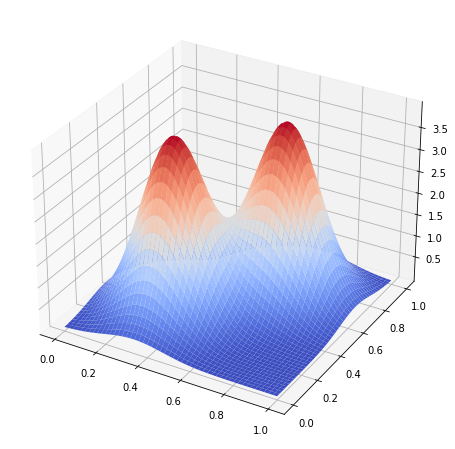

In [36]:
def camel_plot(x):
    pre = tf.cast(1./(alpha*tf.sqrt(np.pi))**ndims, dtype=tf.float64)
    exponent1 = -1.*tf.reduce_sum(((x-(1./3.))**2)/alpha**2, axis=-1)
    exponent2 = -1.*tf.reduce_sum(((x-(2./3.))**2)/alpha**2, axis=-1)
    return 0.5*pre*(tf.exp(exponent1)+tf.exp(exponent2)).numpy()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
zs = np.array(camel_plot(np.vstack([np.ravel(X), np.ravel(Y)]).T))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm')